In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["WANDB_SILENT"] = "true"

In [2]:
import argparse
import os
import statistics
from pathlib import Path

import numpy as np
import pandas as pd
import src.BertClassifier as BertClassifier
import src.influence as inf_utils
import src.utils as utils
import torch
import yaml
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

import wandb

device = utils.get_device()
config_path = "loo/classifier.yaml"
epochs = 5
num_training_examples = 1000

with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({"epochs": epochs, "num_training_examples": num_training_examples})

# Create datasets
train_dataset = create_train_sst2(
    device,
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)

test_dataset = create_test_sst2(
    device,
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10525.17it/s]


## Train Model on Full Data

In [3]:
def train_model(
    train_dataset, test_dataset, config, wandb_project="LOO-test", wandb_tags=None
):
    train_dataloader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )

    # Create classifcation model
    model = BertClassifier.create_bert_classifier(
        config["bert_model_name"],
        classifier_type=config["classifier_type"],
        classifier_hidden_size=config["classifier_hidden_size"],
        classifier_drop_out=config["classifier_drop_out"],
        freeze_bert=True,
        # random_state=42,
    )
    model.classifier.load_state_dict(
        torch.load("loo_10k/run_0/init_classifier_params.pt")
    )
    # torch.save(model.classifier.state_dict(), 'classifier_params.pt')

    optimizer = Adam(model.classifier.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.CrossEntropyLoss()

    run = wandb.init(project=wandb_project, tags=wandb_tags, config=config)

    utils.train(
        config=config,
        model=model,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        val_dataloader=None,
    )

    fdf, test_loss, test_acc = utils.evaluate_loss_df(model, test_dataloader)
    wandb.summary["test/loss"] = test_loss
    wandb.summary["test/accuracy"] = test_acc
    wandb.finish()

    return model, fdf, test_loss, test_acc

In [4]:
full_model, fdf, full_test_loss, full_test_acc = train_model(
    train_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 27.08batch/s]


In [5]:
TEST_GUID = 716

fdf[fdf.test_guid == TEST_GUID]

,test_guid,logits,pred,label,loss
716,716,"[0.69762474, -0.95851254]",0,0,0.174688


In [6]:
np.argsort(fdf.loss)[300]

257

In [7]:
fdf[fdf.test_guid == 716]

,test_guid,logits,pred,label,loss
716,716,"[0.69762474, -0.95851254]",0,0,0.174688


## Compute Loss Influence

In [8]:
param_infl = list(full_model.classifier.parameters())
infl = inf_utils.compute_influence(
    full_model=full_model,
    test_guid=TEST_GUID,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=2,
    lissa_depth=1,
    damping=5e-3,
    scale=100,
    # training_indices=list(range(15)),
)

LiSSA reps: 2 and num_iterations: 1000
Recursion at depth 0: norm is 4.655922
Recursion at depth 200: norm is 127.890549
Recursion at depth 400: norm is 165.555710
Recursion at depth 600: norm is 177.680008
Recursion at depth 800: norm is 182.073212
Recursion at depth 999: norm is 183.608948
Recursion at depth 0: norm is 4.609522
Recursion at depth 200: norm is 128.841476
Recursion at depth 400: norm is 166.395264
Recursion at depth 600: norm is 178.216537
Recursion at depth 800: norm is 181.195511
Recursion at depth 999: norm is 182.774078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.29it/s]


## Compute LOO Chart

In [9]:
def centered_percentile_idxs(infl, remove_length):
    half = int(len(infl) / 2)
    start_index = max(0, half - int(remove_length / 2))
    end_index = start_index + remove_length
    return np.argsort(infl)[start_index:end_index]

In [18]:

def compute_loo_sweep(test_guid: int) -> pd.DataFrame:
    loo_dfs = []

    for remove_pct in np.arange(0.05, 0.8, 0.05):
        remove_length = int(remove_pct * len(train_dataset))

        # Remove random indices
        remove_idxs = np.random.randint(low=0, high=len(train_dataset), size=remove_length)
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        _, rdf, rad_test_loss, rand_test_acc = train_model(
            loo_dataset,
            test_dataset,
            config,
        )
        rdf["type"] = "rand"

        # Remove top influence score
        remove_idxs = np.argsort(-infl)[:remove_length]
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        _, tdf, rad_test_loss, rand_test_acc = train_model(
            loo_dataset, test_dataset, config
        )
        tdf["type"] = "top"

        # Remove bottom influence score
        remove_idxs = np.argsort(infl)[:remove_length]
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        _, bdf, rad_test_loss, rand_test_acc = train_model(
            loo_dataset, test_dataset, config
        )
        bdf["type"] = "bot"

        # Remove near 0 influence score
        remove_idxs = centered_percentile_idxs(infl, remove_length)
        loo_dataset = create_loo_dataset(train_dataset, remove_idxs)
        _, zdf, rad_test_loss, rand_test_acc = train_model(
            loo_dataset, test_dataset, config
        )
        zdf["type"] = "zero"

        df = pd.concat([rdf, tdf, bdf, zdf], axis=0)
        df["remove_pct"] = remove_pct

        loo_dfs.append(df)
    return pd.concat(loo_dfs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 31.25batch/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel:

In [20]:
df = pd.concat(loo_dfs)
#df.to_csv('loo_dfs_0.csv', index=False)

In [21]:
df[(df.type=='rand') & (df.test_guid==TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
716,716,"[0.83846045, -1.0993491]",0,0,0.134548,rand,0.05
716,716,"[0.6961023, -0.9569932]",0,0,0.175176,rand,0.10
716,716,"[0.93669856, -1.197588]",0,0,0.111836,rand,0.15
716,716,"[1.0138788, -1.274768]",0,0,0.096585,rand,0.20
716,716,"[0.8289618, -1.0898498]",0,0,0.136959,rand,0.25
716,716,"[1.3947383, -1.6556265]",0,0,0.046255,rand,0.30
716,716,"[0.8246898, -1.0855777]",0,0,0.138057,rand,0.35


In [22]:
df[(df.type=='top') & (df.test_guid==TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
716,716,"[-0.39697048, 0.13608003]",1,0,0.994778,top,0.05
716,716,"[-0.7447713, 0.48388174]",1,0,1.485376,top,0.10
716,716,"[-1.0913144, 0.83042586]",1,0,2.058325,top,0.15
716,716,"[-1.9852375, 1.724348]",1,0,3.733778,top,0.20
716,716,"[-2.9003928, 2.6395035]",1,0,5.543815,top,0.25
716,716,"[-3.1055737, 2.8446865]",1,0,5.952862,top,0.30
716,716,"[-3.9295309, 3.6686423]",1,0,7.598674,top,0.35


In [23]:
df[(df.type=='bot') & (df.test_guid==TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
716,716,"[2.100982, -2.3618705]",0,0,0.011463,bot,0.05
716,716,"[2.7790165, -3.0399067]",0,0,0.002966,bot,0.10
716,716,"[2.7678113, -3.0286999]",0,0,0.003034,bot,0.15
716,716,"[3.3702934, -3.6311822]",0,0,0.000910,bot,0.20
716,716,"[3.9287324, -4.1896214]",0,0,0.000298,bot,0.25
716,716,"[4.2095137, -4.4704013]",0,0,0.000170,bot,0.30
716,716,"[4.7423162, -5.0032063]",0,0,0.000059,bot,0.35


In [24]:
df[(df.type=='zero') & (df.test_guid==TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
716,716,"[0.9271721, -1.1880627]",0,0,0.113869,zero,0.05
716,716,"[0.6881714, -0.94906056]",0,0,0.177743,zero,0.10
716,716,"[0.8560215, -1.1169112]",0,0,0.130193,zero,0.15
716,716,"[0.83092123, -1.0918097]",0,0,0.136458,zero,0.20
716,716,"[0.65926033, -0.9201477]",0,0,0.187390,zero,0.25
716,716,"[0.41102013, -0.6719071]",0,0,0.291626,zero,0.30
716,716,"[0.6366099, -0.8974978]",0,0,0.195277,zero,0.35


### Plot

In [32]:
TEST_GUID = 716
base_line_loss = fdf[fdf.test_guid == TEST_GUID].loss.squeeze()

rand = df[(df.type=='rand') & (df.test_guid==TEST_GUID)]
rand = rand[['remove_pct', 'loss']]

zero = df[(df.type=='zero') & (df.test_guid==TEST_GUID)]
zero = zero[['remove_pct', 'loss']]

top = df[(df.type=='top') & (df.test_guid==TEST_GUID)]
top = top[['remove_pct', 'loss']]

bot = df[(df.type=='bot') & (df.test_guid==TEST_GUID)]
bot = bot[['remove_pct', 'loss']]

In [40]:
base_line_loss

0.1746881753206253

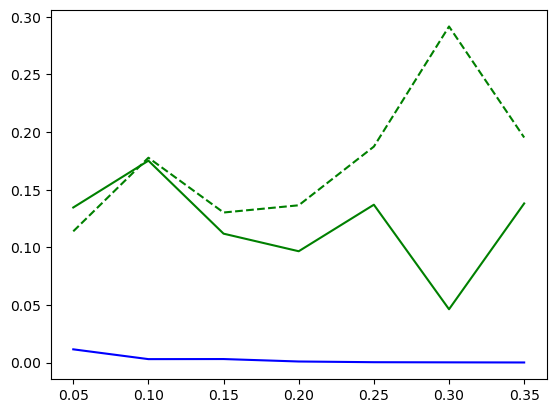

In [42]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, 'g-')
plt.plot(zero.remove_pct, zero.loss, 'g--')

# plt.plot(top.remove_pct, top.loss, 'r-')
plt.plot(bot.remove_pct, bot.loss, 'b-')

In [31]:
rand

,remove_pct,loss
716,0.05,0.134548
716,0.10,0.175176
716,0.15,0.111836
716,0.20,0.096585
716,0.25,0.136959
716,0.30,0.046255
716,0.35,0.138057


## Remove Random 10%

In [ ]:
remove_pct = 0.1


remove_length = int(remove_pct * len(train_dataset))


remove_idxs = np.random.randint(low=0, high=max_idx, size=num_indices)
loo_dataset = create_loo_dataset(train_dataset, remove_idxs)

rand_model, rdf, rad_test_loss, rand_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

## Remove Top 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(-infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

t_model, tdf, top_test_loss, top_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

## Remove Bottom 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

b_model, bdf, bot_test_loss, bot_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
fdf[fdf.test_guid == TEST_GUID]

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

In [ ]:
bdf[bdf.test_guid == TEST_GUID]

In [ ]:
import src.datasets as datasets

datasets.get_test_example(TEST_GUID).sentence.squeeze()

In [ ]:
fdf.sort_values("loss", ascending=False)